In [1]:
! cat /etc/os-release # OS version
! lsb_release -a # OS version
! uname -r # Linux kernel version
! nvcc --version # CUDA version
! python --version #python version

NAME="Ubuntu"
VERSION="20.04.5 LTS (Focal Fossa)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 20.04.5 LTS"
VERSION_ID="20.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=focal
UBUNTU_CODENAME=focal
No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 20.04.5 LTS
Release:	20.04
Codename:	focal
5.10.147+
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
Python 3.8.10


In [2]:
#追加　パッケージのインストーる

!apt install imagemagick # gif作成に必要

# ! pip install flake8
# ! pip install black
# ! pip install isort
# ! pip install mypy
! pip install tqdm
! pip install japanize-matplotlib
! pip install plotly==5.13.1
! pip install pytorch-lightning  

Reading package lists... Done
Building dependency tree       
Reading state information... Done
imagemagick is already the newest version (8:6.9.10.23+dfsg-2.1ubuntu11.4).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import random
import os
import math
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import optim

import torchvision
import torchvision.transforms as transforms

from torchvision.datasets import MNIST, FashionMNIST

import pytorch_lightning as pl

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import japanize_matplotlib
import matplotlib.animation as animation
from matplotlib import animation, rc


import plotly.express as px

from tqdm import tqdm

In [4]:
cmap_keyword = "tab10"
cmap = plt.get_cmap(cmap_keyword)

In [5]:

def torch_fix_seed(seed=42):
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

SEED=42
torch_fix_seed(SEED)

In [6]:
BATCH_SIZE = 200

one_class = 'T-shirt/top',
anomaly_class = 'Trouser'


trainval_data = FashionMNIST("./data", 
                   train=True, 
                   download=True, 
                   transform=transforms.ToTensor())
calss_list = FashionMNIST.classes
print(calss_list)


one_class = 0
anomaly_class = 1

# trainval_data = MNIST("./data", 
#                    train=True, 
#                    download=True, 
#                    transform=transforms.ToTensor())

# print(trainval_data)
# print(type(trainval_data))
# print(trainval_data[0][0])
# print(trainval_data[0][1])

print("original trainval data size: ",len(trainval_data))

anomaly_data = [x for x in trainval_data if x[1]==anomaly_class]
print("anomaly data size: ",len(anomaly_data))

trainval_data = [x for x in trainval_data if x[1]==one_class]
print("trainval data size: ",len(trainval_data))




train_size = int(len(trainval_data) * 0.8)
val_size = int(len(trainval_data) * 0.2)

test_data = trainval_data[train_size+val_size:]
print("test data size: ",len(test_data))
trainval_data = trainval_data[:train_size+val_size]
print("trainval data size: ",len(trainval_data))


train_data, val_data = torch.utils.data.random_split(trainval_data, [train_size, val_size])

train_loader = DataLoader(dataset=train_data,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=0)

val_loader = DataLoader(dataset=val_data,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=0)

anomaly_loader = DataLoader(dataset=anomaly_data,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=0)

print("train data size: ",len(train_data))
print("train iteration number: ",len(train_data)//BATCH_SIZE)
print("val data size: ",len(val_data))
print("val iteration number: ",len(val_data)//BATCH_SIZE)





['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
original trainval data size:  60000
anomaly data size:  6000
trainval data size:  6000
test data size:  0
trainval data size:  6000
train data size:  4800
train iteration number:  24
val data size:  1200
val iteration number:  6


images_size: torch.Size([200, 1, 28, 28])
label: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


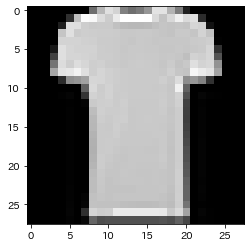

In [7]:
images, labels = next(iter(train_loader))
print("images_size:",images.size())
print("label:",labels[:10])

image_numpy = images.detach().numpy().copy()
plt.imshow(image_numpy[0,0,:,:], cmap='gray')

images_size: torch.Size([200, 1, 28, 28])
label: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


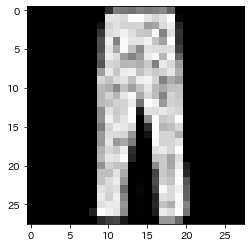

In [8]:
images, labels = next(iter(anomaly_loader))
print("images_size:",images.size())
print("label:",labels[:10])

image_numpy = images.detach().numpy().copy()
plt.imshow(image_numpy[0,0,:,:], cmap='gray')

In [9]:
###########全結合型NNベースのVAE (MNIST)###################
class VAEEncoder(nn.Module):
  def __init__(self, z_dim):
    super().__init__()
    self.lr = nn.Linear(28*28, 300)
    self.lr2 = nn.Linear(300, 100)
    self.lr_ave = nn.Linear(100, z_dim) #mean
    self.lr_dev = nn.Linear(100, z_dim) #log(sigma^2)
    self.relu = nn.ReLU()
  
  def forward(self, x):
    x = self.lr(x)
    x = self.relu(x)
    x = self.lr2(x)
    x = self.relu(x)
    ave = self.lr_ave(x) #mean
    log_dev = self.lr_dev(x) #log(sigma^2)

    ep = torch.randn_like(ave)
    z = ave + torch.exp(log_dev / 2) * ep
    return z, ave, log_dev

class VAEDecoder(nn.Module):
  def __init__(self, z_dim):
    super().__init__()
    self.lr = nn.Linear(z_dim, 100)
    self.lr2 = nn.Linear(100, 300)
    self.lr3 = nn.Linear(300, 28*28)
    self.relu = nn.ReLU()
  
  def forward(self, z):
    x = self.lr(z)
    x = self.relu(x)
    x = self.lr2(x)
    x = self.relu(x)
    x = self.lr3(x)
    x = torch.sigmoid(x)
    return x

class VAE(nn.Module):
  def __init__(self, z_dim):
    super().__init__()
    self.encoder = VAEEncoder(z_dim)
    self.decoder = VAEDecoder(z_dim)
  
  def forward(self, x):
    z, ave, log_dev = self.encoder(x)
    x = self.decoder(z)
    return x, z, ave, log_dev

def criterion(predict, target, ave, log_dev):
  recon_loss = F.binary_cross_entropy(predict, target, reduction='mean')
  kl_loss = -0.5 * torch.sum(1 + log_dev - ave**2 - log_dev.exp())
  loss = recon_loss + kl_loss
  return loss ,recon_loss , kl_loss

In [10]:
#########VAEではなく通常のオートエンコーダ###########

####VAEとAEの違いはガウス分布を仮定しているかどうかで####
####特定の分布を仮定することでKLdivを計算できる(正則化項)####
class AEEncoder(nn.Module):
  def __init__(self, z_dim):
    super().__init__()
    self.lr = nn.Linear(28*28, 300)
    self.lr2 = nn.Linear(300, 100)
    self.lr3 = nn.Linear(100, z_dim) #mean
    self.relu = nn.ReLU()
  
  def forward(self, x):
    x = self.lr(x)
    x = self.relu(x)
    x = self.lr2(x)
    x = self.relu(x)
    x = self.lr3(x)
    return x

class AEDecoder(nn.Module):
  def __init__(self, z_dim):
    super().__init__()
    self.lr = nn.Linear(z_dim, 100)
    self.lr2 = nn.Linear(100, 300)
    self.lr3 = nn.Linear(300, 28*28)
    self.relu = nn.ReLU()
  
  def forward(self, z):
    x = self.lr(z)
    x = self.relu(x)
    x = self.lr2(x)
    x = self.relu(x)
    x = self.lr3(x)
    x = torch.sigmoid(x)
    return x

class AE(nn.Module):
  def __init__(self, z_dim):
    super().__init__()
    self.encoder = AEEncoder(z_dim)
    self.decoder = AEDecoder(z_dim)
  
  def forward(self, x):
    z = self.encoder(x)
    x = self.decoder(z)
    return x, z

def criterion_ae(predict, target):
  loss = F.binary_cross_entropy(predict, target, reduction='mean')
  return loss

# model = AE(z_dim).to(device)
# loss = criterion_ae(output, input)

In [11]:
###########畳み込み型NNベースのVAE (MNIST)###################
class ConvEncoder(nn.Module):
  def __init__(self, z_dim, drop_rate = 0.1):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=2, padding="same")
    self.conv2 = nn.Conv2d(32, 32, kernel_size=2, padding="same")
    self.conv3 = nn.Conv2d(32, 32, kernel_size=2, padding="same")
    self.lr1 = nn.Linear(32*3*3, 100)
    self.lr_ave = nn.Linear(100, z_dim) #mean
    self.lr_dev = nn.Linear(100, z_dim) #log(sigma^2)
    self.bn = nn.BatchNorm2d(32)
    self.relu = nn.ReLU()
    self.maxpool_2D = nn.AvgPool2d(2, stride = 2)
    self.dropout = nn.Dropout(p=drop_rate)
  
  def forward(self, x):
    x = self.conv1(x)
    x = self.bn(x)
    x = self.relu(x)
    x = self.maxpool_2D(x)
    x = self.conv2(x)
    x = self.bn(x)
    x = self.relu(x)
    x = self.maxpool_2D(x)
    x = self.conv3(x)
    x = self.bn(x)
    x = self.relu(x)
    x = self.maxpool_2D(x)

    x = x.view(-1, 32*3*3)
    x = self.lr1(x)
    x = self.relu(x)
    ave = self.lr_ave(x) #mean
    log_dev = self.lr_dev(x) #log(sigma^2)

    ep = torch.randn_like(ave)
    z = ave + torch.exp(log_dev / 2) * ep
    return z, ave, log_dev

class ConvDecoder(nn.Module):
  def __init__(self, z_dim, drop_rate = 0.1):
    super().__init__()
    self.lr1 = nn.Linear(z_dim, 8*3*3)
    self.relu = nn.ReLU()
    self.uc1 = nn.ConvTranspose2d(8, 32, kernel_size =2, stride = 2, output_padding = 1)
    self.uc2 = nn.ConvTranspose2d(32, 32, kernel_size =2, stride = 2)
    self.conv1 = nn.Conv2d(32, 32, kernel_size=3, padding="same")
    self.bn = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32, 1, kernel_size = 1)
    self.dropout = nn.Dropout(p=drop_rate)
  
  def forward(self, x):
    x = self.lr1(x)
    x = self.relu(x)
    x = x.view(-1, 8, 3, 3)
    x = self.uc1(x)
    x = self.conv1(x)
    x = self.bn(x)
    x = self.relu(x)
    x = self.uc2(x)
    x = self.conv1(x)
    x = self.bn(x)
    x = self.relu(x)
    x = self.uc2(x)
    x = self.conv1(x)
    x = self.bn(x)
    x = self.relu(x)
    x = self.conv1(x)
    x = self.bn(x)
    x = self.relu(x)
    x = self.conv1(x)
    x = self.bn(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = torch.sigmoid(x)    
    return x

class ConvVAE(nn.Module):
  def __init__(self, z_dim):
    super().__init__()
    self.encoder = ConvEncoder(z_dim)
    self.decoder = ConvDecoder(z_dim)
  
  def forward(self, x):
    z, ave, log_dev = self.encoder(x)
    x = self.decoder(z)
    return x, z, ave, log_dev

def criterion(predict, target, ave, log_dev):
  recon_loss = F.binary_cross_entropy(predict, target, reduction='mean')
  kl_loss = -0.5 * torch.sum(1 + log_dev - ave**2 - log_dev.exp())
  loss = recon_loss + kl_loss
  return loss ,recon_loss , kl_loss

# model = ConvVAE(z_dim).to(device)
# loss = criterion(output, input, ave, log_dev) #VAE用と同じ

In [12]:
z_dim = 2
num_epochs = 100

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
# model = VAE(z_dim).to(device)
model = AE(z_dim).to(device)
# model = ConvVAE(z_dim).to(device)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

AE(
  (encoder): AEEncoder(
    (lr): Linear(in_features=784, out_features=300, bias=True)
    (lr2): Linear(in_features=300, out_features=100, bias=True)
    (lr3): Linear(in_features=100, out_features=2, bias=True)
    (relu): ReLU()
  )
  (decoder): AEDecoder(
    (lr): Linear(in_features=2, out_features=100, bias=True)
    (lr2): Linear(in_features=100, out_features=300, bias=True)
    (lr3): Linear(in_features=300, out_features=784, bias=True)
    (relu): ReLU()
  )
)


In [13]:
# for i, (x, labels) in enumerate(train_loader):
#     input = x.to(device).to(torch.float32)
#     output, z, ave, log_dev = model(input)

#     history["ave"].append(ave)
#     history["log_dev"].append(log_dev)
#     history["z"].append(z)
#     history["labels"].append(labels)
#     loss = criterion(output, input, ave, log_dev)
     
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
     
#     if (i+1) % 50 == 0:
#       print(f'Epoch: {epoch+1}, loss: {loss: 0.4f}')
#     history["train_loss"].append(loss)


In [14]:
history = {"train_loss": [], 
           "val_input":[], "val_output": [], "val_loss": [], "val_recon_loss":[], "val_ave": [], "val_log_dev": [], "val_z": [], "val_labels":[],
           "anom_input": [],"anom_output":[] ,"anom_loss": [], "anom_recon_loss":[],"anom_ave": [], "anom_log_dev": [], "anom_z": [], "anom_labels":[],
            }

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15], gamma=0.1)

for epoch in tqdm(range(num_epochs)):
  model.train()
  for i, (x, labels) in enumerate(train_loader):

    input = x.to(device).view(-1, 28*28).to(torch.float32)
    # input = x.to(device).to(torch.float32) #ConVAE

    # output, z, ave, log_dev = model(input)
    output, z = model(input) #AE

    # loss, _, _ = criterion(output, input, ave, log_dev) 
    loss = criterion_ae(output, input) 
     
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
     
    # print(ave.shape[0])
    if input.shape[0]==BATCH_SIZE:
        history["train_loss"].append(loss)
    
    
  # print(f'Epoch: {epoch+1}, train_loss: {loss: 0.4f}')

  model.eval()
  with torch.no_grad():
    for i, (x, labels) in enumerate(val_loader):
      input = x.to(device).view(-1, 28*28).to(torch.float32)
      # input = x.to(device).to(torch.float32) #ConVAE

      # output, z, ave, log_dev = model(input)
      output, z = model(input) #AE

      # print(f"{input.shape=}\t{output.shape=}")[200(BATCH_SIZE), 28*28(img_size)]
      # print(f"{input[0].shape=}\t{output[0].shape=}")[28*28(img_size)]

      # loss ,recon_loss , kl_loss = criterion(output, input, ave, log_dev)
      loss = criterion_ae(output, input) 

      if input.shape[0]==BATCH_SIZE:
        history["val_input"].append(input[0])
        history["val_output"].append(output[0])
        # history["val_ave"].append(ave)
        # history["val_log_dev"].append(log_dev)
        history["val_z"].append(z)
        history["val_labels"].append(labels)
        history["val_loss"].append(loss)
        # history["val_recon_loss"].append(recon_loss)
  # print(f'Epoch: {epoch+1}, val_loss: {loss: 0.4f}')

  model.eval()
  with torch.no_grad():
    for i, (x, labels) in enumerate(anomaly_loader):
      input = x.to(device).view(-1, 28*28).to(torch.float32)
      # input = x.to(device).to(torch.float32) #ConVAE

      # output, z, ave, log_dev = model(input)
      output, z = model(input) #AE

      # loss ,recon_loss , kl_loss = criterion(output, input, ave, log_dev)
      loss = criterion_ae(output, input) 

      if input.shape[0]==BATCH_SIZE:
        history["anom_input"].append(input[0])
        history["anom_output"].append(output[0])
        # history["anom_ave"].append(ave)
        # history["anom_log_dev"].append(log_dev)
        history["anom_z"].append(z)
        history["anom_labels"].append(labels)
        history["anom_loss"].append(loss)
        # history["anom_recon_loss"].append(recon_loss)
  # print(f'Epoch: {epoch+1}, anom_loss: {loss: 0.4f}')   
  # print("\n")
  
  scheduler.step()

100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


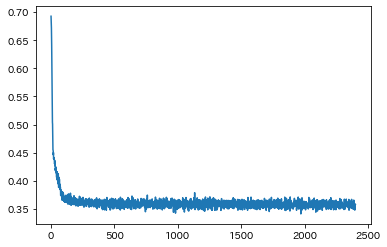

In [15]:
train_loss_tensor = torch.stack(history["train_loss"])
train_loss_np = train_loss_tensor.to('cpu').detach().numpy().copy()
plt.plot(train_loss_np)

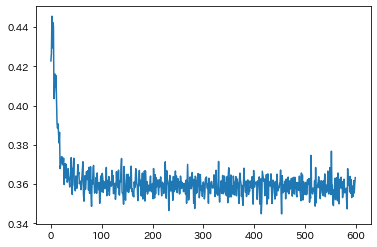

In [16]:
val_loss_tensor = torch.stack(history["val_loss"])
val_loss_np = val_loss_tensor.to('cpu').detach().numpy().copy()
plt.plot(val_loss_np)

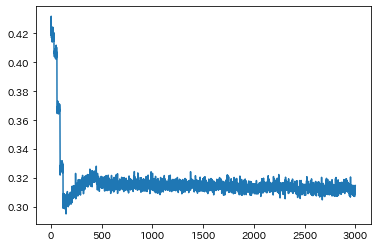

In [17]:
val_loss_tensor = torch.stack(history["anom_loss"])
val_loss_np = val_loss_tensor.to('cpu').detach().numpy().copy()
plt.plot(val_loss_np)

In [18]:
# alpha =3.0
# cnt =0

# tensor_ave = history["val_ave"][-1]
# tensor_log_dev = history["val_log_dev"][-1] #log(sigma^2)
# tensor_recon_loss = history["val_recon_loss"][-1]

# np_ave = tensor_ave.to('cpu').detach().numpy().copy()
# np_log_dev = tensor_log_dev.to('cpu').detach().numpy().copy()
# np_recon_loss = tensor_recon_loss.to('cpu').detach().numpy().copy()

# ave = np_ave
# sigma = np.exp(np_log_dev)/2
# recon_loss = np_recon_loss

# threshold = ave + alpha*sigma

# if recon_loss >= threshold.all():
#   cnt +=1
#   print("this is anomaly img")
# else: 
#   print("this is not anomaly img")
# print(f"anomaly_rate:{cnt/len(history["val_ave"])}")

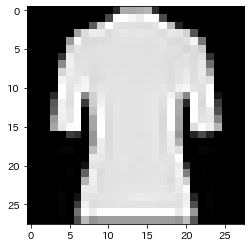

In [19]:
input = history["val_input"][-1]

np_input = input.to('cpu').detach().numpy().copy()
np_image = np.reshape(np_input, (28, 28))
plt.imshow(np_image, cmap='gray')


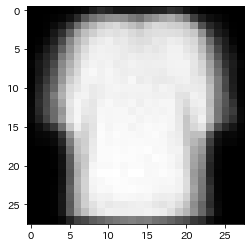

In [20]:

output = history["val_output"][-1]

np_output = output.to('cpu').detach().numpy().copy()
np_image = np.reshape(np_output, (28, 28))
plt.imshow(np_image, cmap='gray')

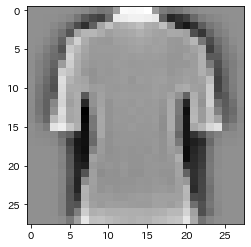

In [21]:
np_diff = np_input - np_output
np_image = np.reshape(np_diff, (28, 28))
plt.imshow(np_image, cmap='gray')

In [22]:
# alpha =3.0
# cnt =0

# tensor_ave = history["anom_ave"][-1]
# tensor_log_dev = history["anom_log_dev"][-1] #log(sigma^2)
# tensor_recon_loss = history["anom_recon_loss"][-1]

# np_ave = tensor_ave.to('cpu').detach().numpy().copy()
# np_log_dev = tensor_log_dev.to('cpu').detach().numpy().copy()
# np_recon_loss = tensor_recon_loss.to('cpu').detach().numpy().copy()

# ave = np_ave
# sigma = np.exp(np_log_dev)/2
# recon_loss = np_recon_loss

# threshold = ave + alpha*sigma

# if recon_loss >= threshold.all():
#   cnt +=1
#   print("this is anomaly img")
# else: 
#   print("this is not anomaly img")
# print(f"anomaly_rate:{cnt/len(history["val_ave"])}")

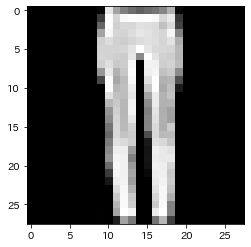

In [23]:
input = history["anom_input"][-1]

np_input = input.to('cpu').detach().numpy().copy()
np_image = np.reshape(np_input, (28, 28))
plt.imshow(np_image, cmap='gray')

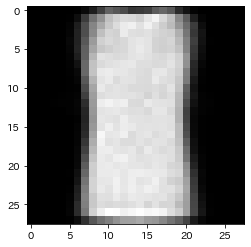

In [24]:
output = history["anom_output"][-1]

np_output = output.to('cpu').detach().numpy().copy()
np_image = np.reshape(np_output, (28, 28))
plt.imshow(np_image, cmap='gray')

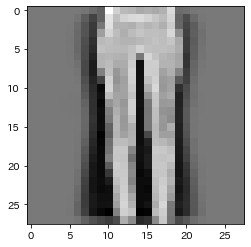

In [25]:
np_diff = np_input - np_output
np_image = np.reshape(np_diff, (28, 28))
plt.imshow(np_image, cmap='gray')

In [26]:
#(解決済) BATCH のデカさが最後ばらつくためエラー出る
ave_tensor = torch.stack(history["val_ave"]) 
log_var_tensor = torch.stack(history["val_log_dev"])
z_tensor = torch.stack(history["val_z"])
labels_tensor = torch.stack(history["val_labels"])
print(ave_tensor.size())
print(log_var_tensor.size())
print(z_tensor.size())
print(labels_tensor.size())

ave_np = ave_tensor.to('cpu').detach().numpy().copy()
log_var_np = log_var_tensor.to('cpu').detach().numpy().copy()
z_np = z_tensor.to('cpu').detach().numpy().copy()
labels_np = labels_tensor.to('cpu').detach().numpy().copy()
print(ave_np.shape)
print(log_var_np.shape)
print(z_np.shape)
print(labels_np.shape)

RuntimeError: ignored

In [ ]:
# batch_num =10

# plt.figure(figsize=[10,10])
# for label in range(10):
#   x = z_np[:batch_num,:,0][labels_np[:batch_num,:] == label]
#   y = z_np[:batch_num,:,1][labels_np[:batch_num,:] == label]
#   plt.scatter(x, y, color=cmap(label/9), label=label, s=15)
#   plt.annotate(label, xy=(np.mean(x),np.mean(y)),size=20,color="black")
# plt.legend(loc="upper left")


In [ ]:
# batch_num = 30

# plt.figure(figsize=[10,10])

# for label in range(10):
#   x = z_np[batch_num:,:,0][labels_np[batch_num:,:] == label]
#   y = z_np[batch_num:,:,1][labels_np[batch_num:,:] == label]
#   plt.scatter(x, y, color=cmap(label/9), label=label, s=15)
#   plt.annotate(label, xy=(np.mean(x),np.mean(y)),size=20,color="black")
# plt.legend(loc="upper left")

In [ ]:
batch_num = 30
label = 0
x_zero_mean = np.mean(ave_np[batch_num:,:,0][labels_np[batch_num:,:] == label])
y_zero_mean = np.mean(ave_np[batch_num:,:,1][labels_np[batch_num:,:] == label])

# label = 1
# x_one_mean = np.mean(ave_np[batch_num:,:,0][labels_np[batch_num:,:] == label])
# y_one_mean = np.mean(ave_np[batch_num:,:,1][labels_np[batch_num:,:] == label])

z_zero = torch.tensor([x_zero_mean,y_zero_mean], dtype = torch.float32)
# z_one = torch.tensor([x_one_mean,y_one_mean], dtype = torch.float32)

In [ ]:
model.to("cpu")
output = model.decoder(z_zero)

np_output = output.to('cpu').detach().numpy().copy()
np_image = np.reshape(np_output, (28, 28))
plt.imshow(np_image, cmap='gray')

In [ ]:
# output = model.decoder(z_one)
# np_output = output.to('cpu').detach().numpy().copy()
# np_image = np.reshape(np_output, (28, 28))
# plt.imshow(np_image, cmap='gray')

In [ ]:
# def plot(frame):
#     plt.cla()                      # 現在描写されているグラフを消去
#     z_zerotoone = ((99 - frame) * z_zero +  frame * z_one) / 99
#     output = model.decoder(z_zerotoone)
#     np_output = output.detach().numpy().copy()
#     np_image = np.reshape(np_output, (28, 28))
#     plt.imshow(np_image, cmap='gray')
#     plt.xticks([]);plt.yticks([])
#     plt.title("frame={}".format(frame))


# fig = plt.figure(figsize=(4,4))
# ani = animation.FuncAnimation(fig, plot, frames=99, interval=100)
# rc('animation', html='jshtml')
# #ani.save("./vae_zerotone.gif", writer="imagemagick")
# ani

In [ ]:
###########全結合型NNベースのVAE (FashionMNIST)###################
class Encoder(nn.Module):
  def __init__(self, z_dim):
    super().__init__()
    self.lr = nn.Linear(28*28, 300)
    self.lr2 = nn.Linear(300, 100)
    self.lr_ave = nn.Linear(100, z_dim) #mean
    self.lr_dev = nn.Linear(100, z_dim) #log(sigma^2)
    self.relu = nn.ReLU()
  
  def forward(self, x):
    x = self.lr(x)
    x = self.relu(x)
    x = self.lr2(x)
    x = self.relu(x)
    ave = self.lr_ave(x) #mean
    log_dev = self.lr_dev(x) #log(sigma^2)

    ep = torch.randn_like(ave)
    z = ave + torch.exp(log_dev / 2) * ep
    return z, ave, log_dev

class Decoder(nn.Module):
  def __init__(self, z_dim):
    super().__init__()
    self.lr = nn.Linear(z_dim, 100)
    self.lr2 = nn.Linear(100, 300)
    self.lr3 = nn.Linear(300, 28*28)
    self.relu = nn.ReLU()
  
  def forward(self, z):
    x = self.lr(z)
    x = self.relu(x)
    x = self.lr2(x)
    x = self.relu(x)
    x = self.lr3(x)
    x = torch.sigmoid(x)
    return x

class VAE(nn.Module):
  def __init__(self, z_dim):
    super().__init__()
    self.encoder = Encoder(z_dim)
    self.decoder = Decoder(z_dim)
  
  def forward(self, x):
    z, ave, log_dev = self.encoder(x)
    x = self.decoder(z)
    return x, z, ave, log_dev

def criterion(predict, target, ave, log_dev):
  recon_loss = F.binary_cross_entropy(predict, target, reduction='sum')
  kl_loss = -0.5 * torch.sum(1 + log_dev - ave**2 - log_dev.exp())
  loss = recon_loss + kl_loss
  return loss

In [ ]:
###########畳み込み型NNベースのVAE (FashionMNIST)###################
class Encoder(nn.Module):
  def __init__(self, z_dim, drop_rate = 0.1):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=2, padding="same")
    self.conv2 = nn.Conv2d(32, 32, kernel_size=2, padding="same")
    self.conv3 = nn.Conv2d(32, 32, kernel_size=2, padding="same")
    self.lr1 = nn.Linear(32*3*3, 100)
    self.lr_ave = nn.Linear(100, z_dim) #mean
    self.lr_dev = nn.Linear(100, z_dim) #log(sigma^2)
    self.bn = nn.BatchNorm2d(32)
    self.relu = nn.ReLU()
    self.maxpool_2D = nn.AvgPool2d(2, stride = 2)
    self.dropout = nn.Dropout(p=drop_rate)
  
  def forward(self, x):
    x = self.conv1(x)
    x = self.bn(x)
    x = self.relu(x)
    x = self.maxpool_2D(x)
    x = self.conv2(x)
    x = self.bn(x)
    x = self.relu(x)
    x = self.maxpool_2D(x)
    x = self.conv3(x)
    x = self.bn(x)
    x = self.relu(x)
    x = self.maxpool_2D(x)

    x = x.view(-1, 32*3*3)
    x = self.lr1(x)
    x = self.relu(x)
    ave = self.lr_ave(x) #mean
    log_dev = self.lr_dev(x) #log(sigma^2)

    ep = torch.randn_like(ave)
    z = ave + torch.exp(log_dev / 2) * ep
    return z, ave, log_dev

class Decoder(nn.Module):
  def __init__(self, z_dim, drop_rate = 0.1):
    super().__init__()
    self.lr1 = nn.Linear(z_dim, 8*3*3)
    self.relu = nn.ReLU()
    self.uc1 = nn.ConvTranspose2d(8, 32, kernel_size =2, stride = 2, output_padding = 1)
    self.uc2 = nn.ConvTranspose2d(32, 32, kernel_size =2, stride = 2)
    self.conv1 = nn.Conv2d(32, 32, kernel_size=3, padding="same")
    self.bn = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32, 1, kernel_size = 1)
    self.dropout = nn.Dropout(p=drop_rate)
  
  def forward(self, x):
    x = self.lr1(x)
    x = self.relu(x)
    x = x.view(-1, 8, 3, 3)
    x = self.uc1(x)
    x = self.conv1(x)
    x = self.bn(x)
    x = self.relu(x)
    x = self.uc2(x)
    x = self.conv1(x)
    x = self.bn(x)
    x = self.relu(x)
    x = self.uc2(x)
    x = self.conv1(x)
    x = self.bn(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = torch.sigmoid(x)    
    return x

class VAE(nn.Module):
  def __init__(self, z_dim):
    super().__init__()
    self.encoder = Encoder(z_dim)
    self.decoder = Decoder(z_dim)
  
  def forward(self, x):
    z, ave, log_dev = self.encoder(x)
    x = self.decoder(z)
    return x, z, ave, log_dev